<a href="https://colab.research.google.com/github/mzamarron/MachineLearning/blob/main/KNNvsPCA%2BKNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>KNN vs PCA + KNN</center>


## Library import

In [ ]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 8)

***

# Data import

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/MachineLearning/Datasets/BreastCancer.csv')
print('Dataset dimension:', df.shape)
df.head()

Dataset dimension: (569, 33)


,id,diagnosis,radius_mean,texture_mean,...,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,...,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,...,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,...,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,...,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,...,0.1625,0.2364,0.07678,NaN


# Data exploration

In [ ]:
# Check for invalid data
df.isna().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [ ]:
# Cleaning the data
df.drop(['Unnamed: 32','id'], axis=1, inplace=True) #Removing noisy columns
df['diagnosis'] = df['diagnosis'].map({'B': 0, 'M': 1}).astype(int) #Label change

0    357
1    212
Name: diagnosis, dtype: int64


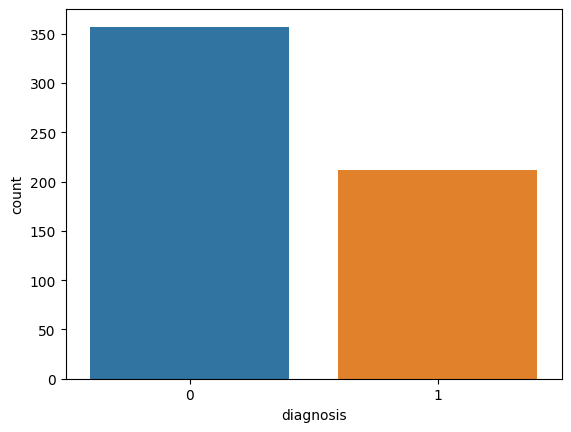

In [ ]:
# Class balance visualization
sns.countplot(x=df['diagnosis'])
print(df['diagnosis'].value_counts()) 

In [ ]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
diagnosis,569.0,0.372583,0.483918,0.000000,0.000000,0.000000,1.000000,1.00000
radius_mean,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
texture_mean,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
perimeter_mean,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
area_mean,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
smoothness_mean,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
compactness_mean,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
concavity_mean,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
concave points_mean,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
symmetry_mean,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400


# Data analysis

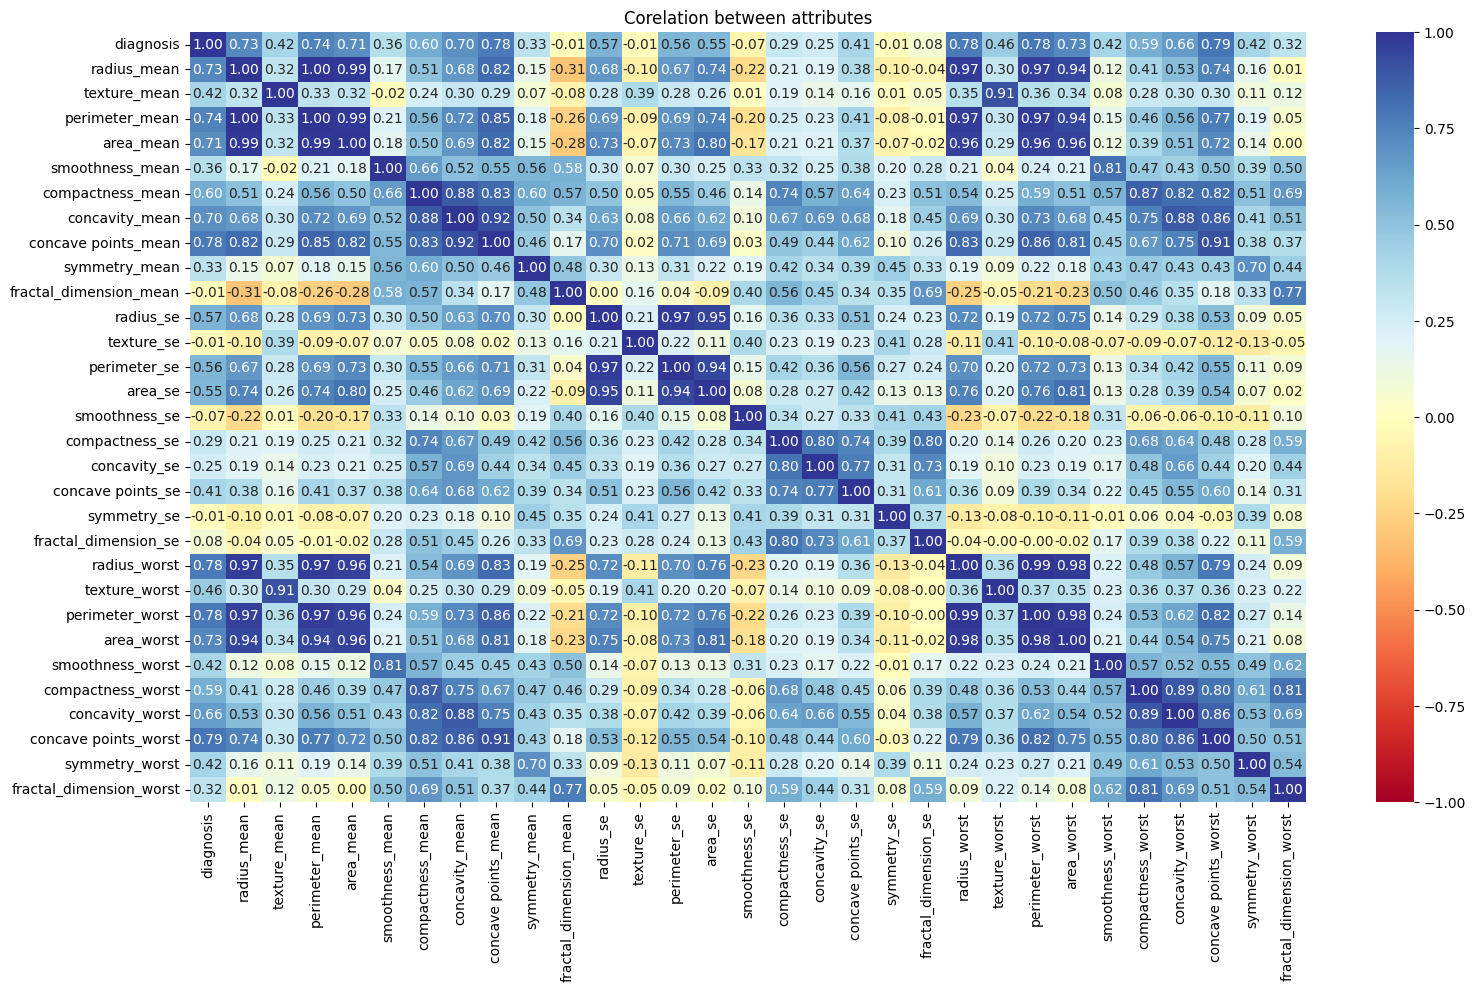

In [ ]:
# Correlation matrix to observe the attribute's relationship and the most 
# linearly related variables. 
corr_matrix = df.corr()

plt.figure(figsize=(18,10))
sns.heatmap(corr_matrix,annot = True, fmt = '.2f', cmap='RdYlBu', vmin=-1, vmax=1)
plt.title('Corelation between attributes')
plt.show()

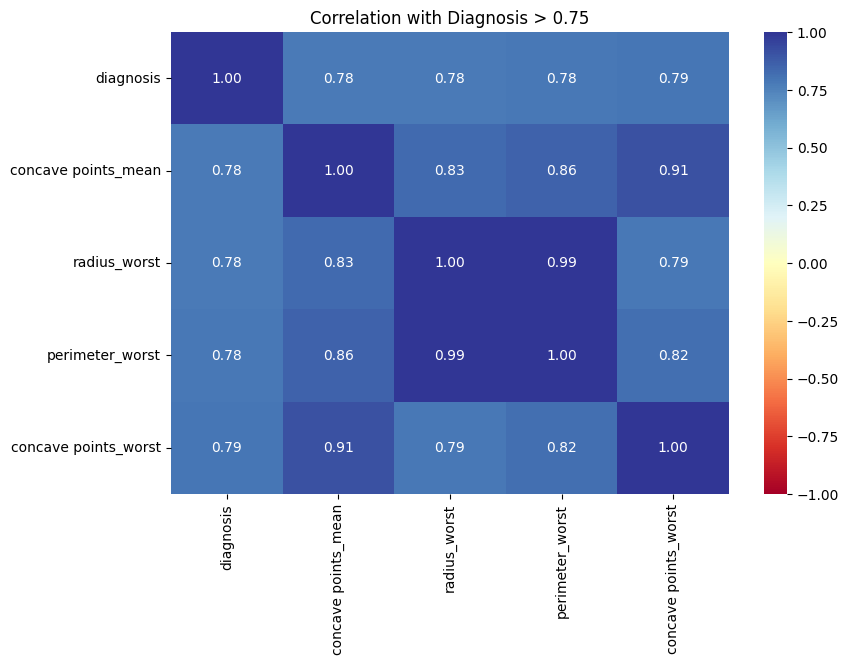


List of most correlated attributes with diagnosis:
 ['concave points_mean', 'radius_worst', 'perimeter_worst', 'concave points_worst']


In [ ]:
# Correlation with a 0.75 threshold for a better visualization
threshold = 0.75

atributtes_corr = np.abs(corr_matrix['diagnosis']) > threshold 
correlation = corr_matrix.columns[atributtes_corr].tolist()

plt.figure(figsize=(9,6))
sns.heatmap(df[correlation].corr(), annot = True, fmt = '.2f',cmap='RdYlBu', vmin=-1, vmax=1)
plt.title('Correlation with Diagnosis > 0.75')
plt.show()

print('\nList of most correlated attributes with diagnosis:\n', correlation[1:])

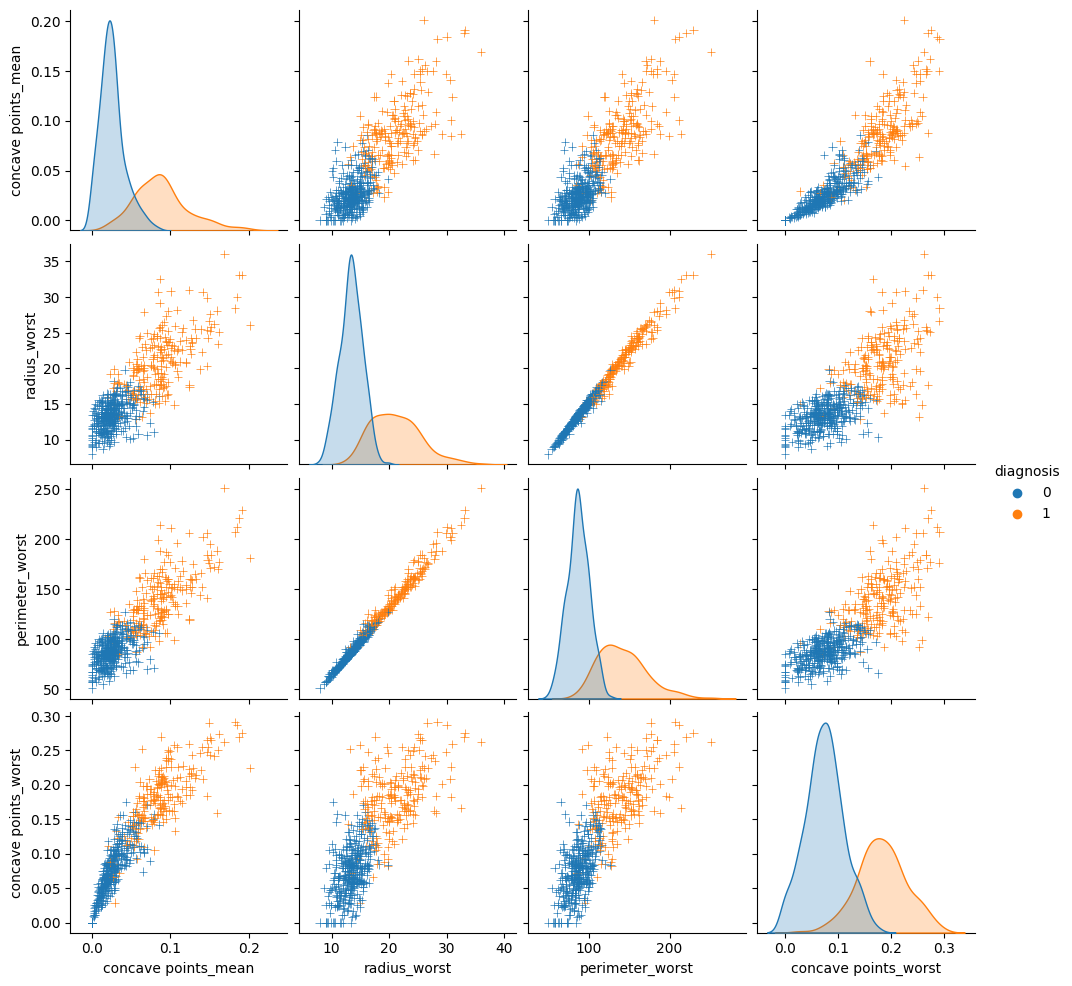

In [ ]:
# Distribution visualization of variable against each other and their
# relationship to the diagnosis.
sns.pairplot(df[correlation], diag_kind = 'kde', markers = '+', hue = 'diagnosis')
plt.show()

# Data normalization

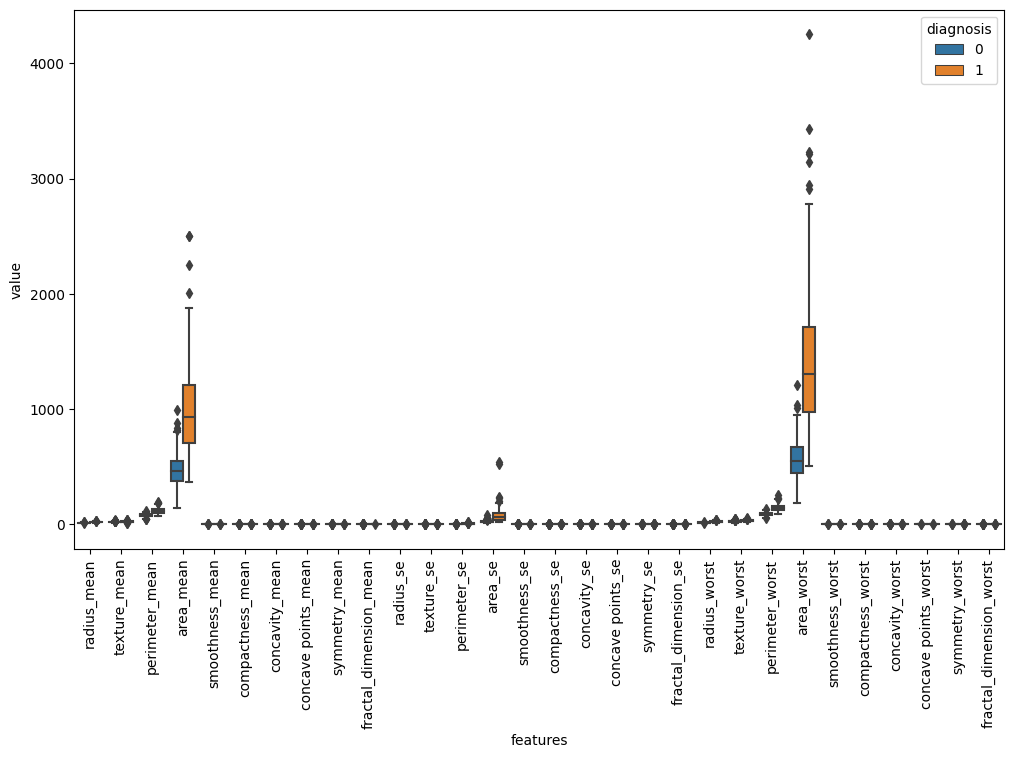

In [ ]:
# Showing the importance of data normalization
df_melted = pd.melt(df, id_vars = 'diagnosis', var_name = 'features', value_name = 'value')

plt.figure(figsize=(12,7))
sns.boxplot(x = 'features', y = 'value', hue = 'diagnosis', data = df_melted)
plt.xticks(rotation = 90) 
plt.show()

In [ ]:
# Normalization
scaler = StandardScaler()
df_std = scaler.fit_transform(df.iloc[:,1:])
df_std = pd.DataFrame(df_std, columns = df.iloc[:,1:].columns)
df_std.insert(loc=0, column='diagnosis', value =df['diagnosis'].values)
# Show normalized dataset
df_std

,diagnosis,radius_mean,texture_mean,perimeter_mean,...,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,1.097064,-2.073335,1.269934,...,2.109526,2.296076,2.750622,1.937015
1,1,1.829821,-0.353632,1.685955,...,-0.146749,1.087084,-0.243890,0.281190
2,1,1.579888,0.456187,1.566503,...,0.854974,1.955000,1.152255,0.201391
3,1,-0.768909,0.253732,-0.592687,...,1.989588,2.175786,6.046041,4.935010
4,1,1.750297,-1.151816,1.776573,...,0.613179,0.729259,-0.868353,-0.397100
...,...,...,...,...,...,...,...,...,...
564,1,2.110995,0.721473,2.060786,...,0.664512,1.629151,-1.360158,-0.709091
565,1,1.704854,2.085134,1.615931,...,0.236573,0.733827,-0.531855,-0.973978
566,1,0.702284,2.045574,0.672676,...,0.326767,0.414069,-1.104549,-0.318409
567,1,1.838341,2.336457,1.982524,...,3.197605,2.289985,1.919083,2.219635


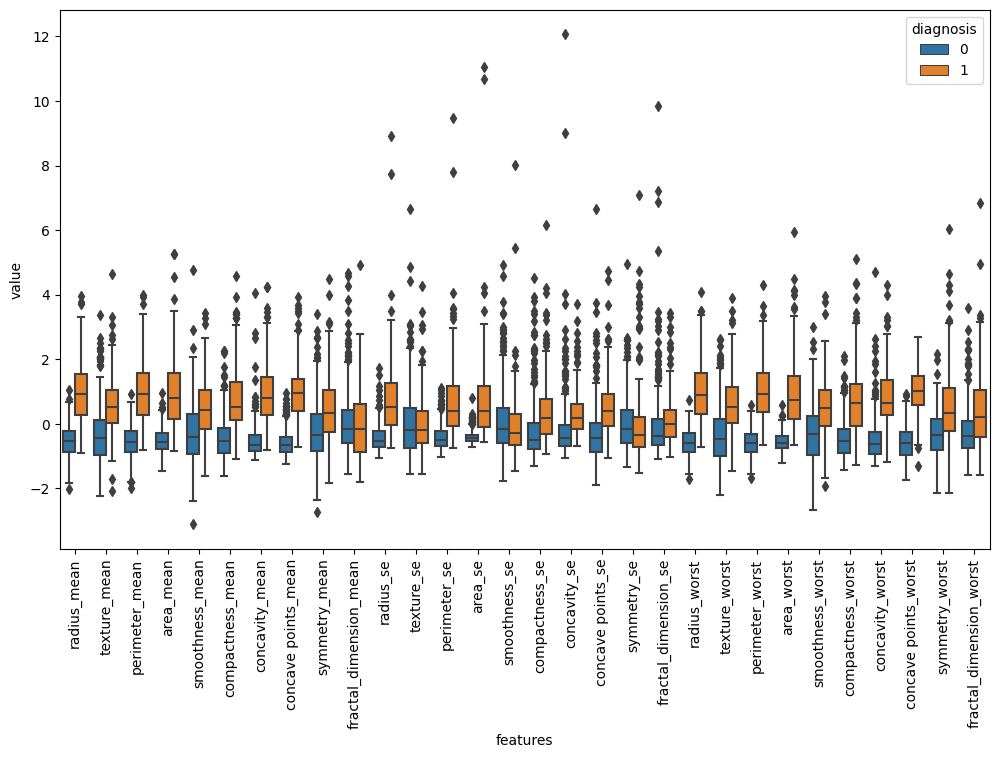

In [ ]:
# Boxplot of normalized data
df_melted = pd.melt(df_std, id_vars = 'diagnosis', var_name = 'features', value_name = 'value')

plt.figure(figsize=(12,7))
sns.boxplot(x = 'features', y = 'value', hue = 'diagnosis', data = df_melted)
plt.xticks(rotation = 90) 
plt.show()

***

#<center> Model Creation </center>

In [ ]:
# Collecting the data
X = df_std.iloc[:,1:]
y = df_std.iloc[:,0]

# Division of data into Training & Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Dimension of X_train:", X_train.shape)
print("Dimension of X_test:", X_test.shape)
print("Dimension of y_train:", y_train.shape)
print("Dimension of y_test:", y_test.shape)

Dimension of X_train: (455, 30)
Dimension of X_test: (114, 30)
Dimension of y_train: (455,)
Dimension of y_test: (114,)


# KNN

## Hyperparameters gridsearch

In [ ]:
# The aim is to obtain the best parameter to run the knn model
nn = list(range(1,21,2))
knn_model = KNeighborsClassifier()
distances = ['euclidean','manhattan','chebyshev']

# Parameter initialization of the gridsearch
param_grid = dict(n_neighbors=nn, weights=['distance'], metric=distances)
gs = GridSearchCV(estimator=knn_model, param_grid=param_grid, 
                  scoring="accuracy", cv=15)

# Fitting of the gridsearch
grid_search = gs.fit(X_train,y_train)
best_score = grid_search.best_score_
best_parameters = grid_search.best_params_

# Gridsearch results
print('Maximum accuracy:', best_score)
print('Optimum Parameters:', best_parameters)

Maximum accuracy: 0.9713261648745521
Optimum Parameters: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}


## Training & Testing

In [ ]:
# Model fitting with best parameters
knn = KNeighborsClassifier(metric=best_parameters['metric'], 
                           n_neighbors=best_parameters['n_neighbors'],
                           weights=best_parameters['weights'])

knn.fit(X_train, y_train) # Training 
y_pred = knn.predict(X_test) # Testing

## Evaluation results

-------------------------------------------------------------------
                      EVALUATION RESULTS
-------------------------------------------------------------------
Modelo    = KNN
K-vecinos =  9
Distancia =  euclidean
-------------------------------------------------------------------


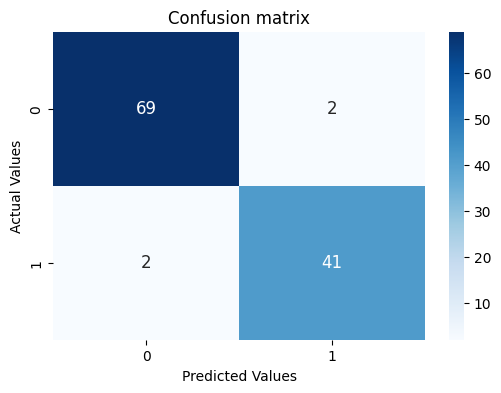

-------------------------------------------------------------------
METRICS
-------------------------------------------------------------------
Accuracy  : 0.9649
Precisión : 0.9627
Recall    : 0.9627
F1 Score  : 0.9627


In [ ]:
print('-------------------------------------------------------------------')
print('                      EVALUATION RESULTS')
print('-------------------------------------------------------------------')
print('Modelo    = KNN')
print('K-vecinos = ',best_parameters['n_neighbors'])
print('Distancia = ', best_parameters['metric'])
print('-------------------------------------------------------------------')
cm = confusion_matrix(y_test,y_pred)
cm = pd.DataFrame(cm)
plt.figure(figsize = (6,4))
sns.heatmap(cm, annot=True, fmt='g', annot_kws={'size':12}, cmap="Blues")
plt.title('Confusion matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show() 
print('-------------------------------------------------------------------')
print('METRICS')
print('-------------------------------------------------------------------')
report = classification_report(y_test, np.array(y_pred), output_dict=True)
print('Accuracy  :', round(report['accuracy'],4))
print('Precisión :', round(report['macro avg']['precision'],4))
print('Recall    :', round(report['macro avg']['recall'],4))
print('F1 Score  :', round(report['macro avg']['f1-score'],4))

# PCA

In [ ]:
# Dimensionallity reduction
pca = PCA(n_components = 2)
pca.fit(df_std.iloc[:,1:])
reduced_pca = pca.transform(df_std.iloc[:,1:])

# Converting reduced data into a dataFrame
df_pca = pd.DataFrame(reduced_pca,columns=['p1','p2'])
df_pca.insert(loc=0, column='diagnosis', value =df['diagnosis'].values)

In [ ]:
# Division nto Training & Testing
X_train, X_test, y_train, y_test = train_test_split(df_pca.iloc[:,1:], df_pca.iloc[:,0], test_size=0.2, random_state=42)
print("Dimension of X_train:", X_train.shape)
print("Dimension of X_test:", X_test.shape)
print("Dimension of y_train:", y_train.shape)
print("Dimension of y_test:", y_test.shape)

Dimension of X_train: (455, 2)
Dimension of X_test: (114, 2)
Dimension of y_train: (455,)
Dimension of y_test: (114,)


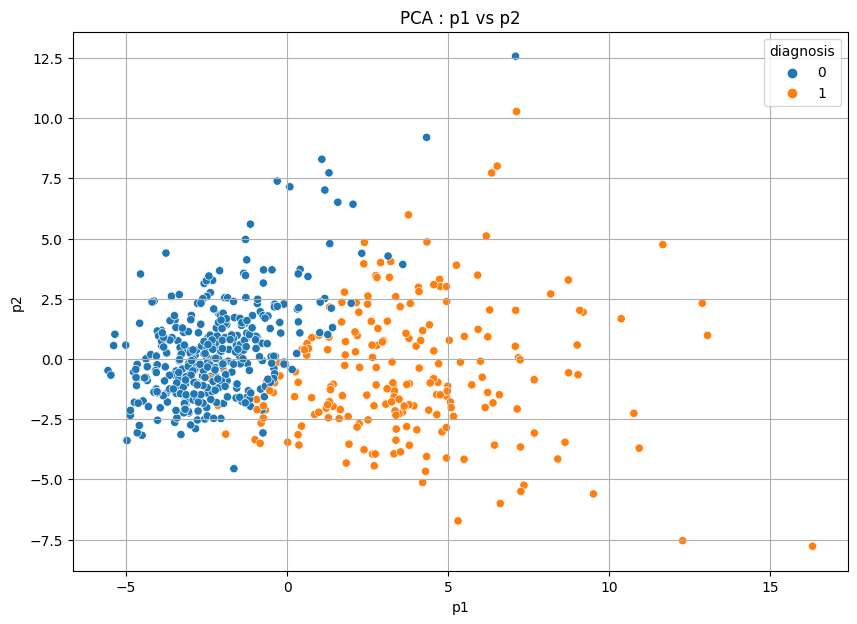

In [ ]:
# PCA scatter plot
plt.figure(figsize=(10,7))
sns.scatterplot(x = 'p1', y = 'p2', hue = 'diagnosis', data = df_pca)
plt.title('PCA : p1 vs p2')
plt.grid()

## Hyperparameters gridsearch

In [ ]:
# Parameter initialization of the gridsearch
pca_knn = KNeighborsClassifier()
gs = GridSearchCV(estimator=pca_knn, param_grid=param_grid,
                  scoring="accuracy", cv=10) 

# Fitting of the gridsearch
grid_search = gs.fit(X_train,y_train)
best_score = grid_search.best_score_
best_parameters = grid_search.best_params_

# Gridsearch results
print('Maximum accuracy:', best_score)
print('Optimum Parameters:', best_parameters)

Maximum accuracy: 0.9252173913043478
Optimum Parameters: {'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'distance'}


## Training & Testing

In [ ]:
# Model fitting with best parameters
pca_knn = KNeighborsClassifier(metric=best_parameters['metric'],
                               n_neighbors=best_parameters['n_neighbors'],
                               weights=best_parameters['weights'])


pca_knn.fit(X_train, y_train) # Training
y_pred = pca_knn.predict(X_test) # Testing

## Evaluation results

-------------------------------------------------------------------
                      EVALUATION RESULTS
-------------------------------------------------------------------
Modelo    = PCA + KNN
K-vecinos =  19
Distancia =  euclidean
-------------------------------------------------------------------


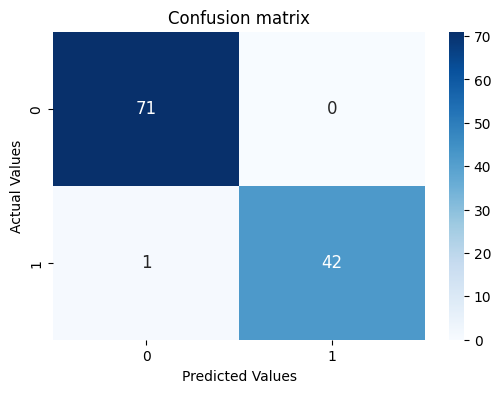

-------------------------------------------------------------------
METRICS
-------------------------------------------------------------------
Accuracy  : 0.9912
Precisión : 0.9931
Recall    : 0.9884
F1 Score  : 0.9906


In [ ]:
print('-------------------------------------------------------------------')
print('                      EVALUATION RESULTS')
print('-------------------------------------------------------------------')
print('Modelo    = PCA + KNN')
print('K-vecinos = ',best_parameters['n_neighbors'])
print('Distancia = ', best_parameters['metric'])
print('-------------------------------------------------------------------')
cm = confusion_matrix(y_test,y_pred)
cm = pd.DataFrame(cm)
plt.figure(figsize = (6,4))
sns.heatmap(cm, annot=True, fmt='g', annot_kws={'size':12}, cmap="Blues")
plt.title('Confusion matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show() 
print('-------------------------------------------------------------------')
print('METRICS')
print('-------------------------------------------------------------------')
report = classification_report(y_test, np.array(y_pred), output_dict=True)
print('Accuracy  :', round(report['accuracy'],4))
print('Precisión :', round(report['macro avg']['precision'],4))
print('Recall    :', round(report['macro avg']['recall'],4))
print('F1 Score  :', round(report['macro avg']['f1-score'],4))

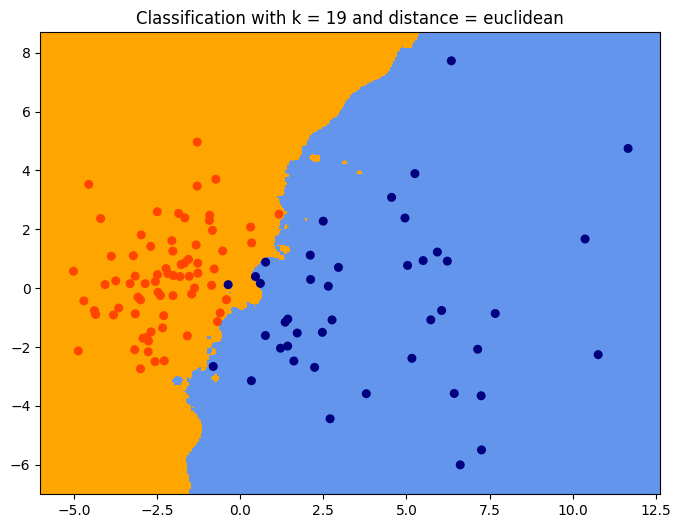

In [ ]:
# Classification results in a visualization
X = X_test.values
y = y_test.values

# Mesh -----------------------------------------------------------------------
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                    np.arange(y_min, y_max, 0.05))
# Modelo ---------------------------------------------------------------------
Z = pca_knn.predict(np.c_[xx.ravel(), yy.ravel()])
# Zonas de decisión ----------------------------------------------------------
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8,6))
plt.pcolormesh(xx, yy, Z, 
                cmap=ListedColormap(['orange', 'cornflowerblue']))
# Puntos ---------------------------------------------------------------------
plt.scatter(X[:, 0], X[:, 1], c=y, 
            cmap=ListedColormap(['orangered', 'navy']), s=30)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Classification with k = {} and distance = {}'.format(best_parameters['n_neighbors'], best_parameters['metric']))
plt.show()